In [29]:
# Forecast for Venezuela Border Arrivals using Facebook Prophet
# Documentation here: https://facebook.github.io/prophet/docs/quick_start.html
# Using arrivals data compiled from different files (script is on Github)
# Follows procedures outlined in the modeling guidelines for this project

# @Cath if there's anything here that's confusing and/or buggy, don't hesitate to reach out via text :)

In [30]:
# Import the necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [31]:
# @Cath download the dataset and import from your own local storage using the format below
    # (Won't work unless you use your own because it's based on local data)
# Current dataset reads from 2018-07-26 to 2021-08-17

df = pd.read_csv('/Users/maxhampel/downloads/arrivals-pacaraima-updated.csv')
df.head() # Shows the first few columns to verify

,Date,arrivals
0,2018-07-26,641.0
1,2018-07-27,442.0
2,2018-07-28,548.0
3,2018-07-29,342.0
4,2018-07-30,880.0


In [32]:
df.columns = ['ds','y'] # Change column names to "ds" and "y," Prophet convention
# Could use df.isna() here to make sure there are no missing data (I didn't because there are, haha)

<AxesSubplot:xlabel='ds'>

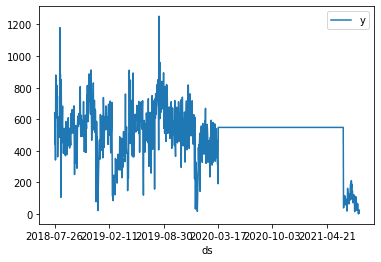

In [33]:
# Line below addresses COVID outliers (March 18, 2020 – June 20, 2021)
# In quadrilateral meeting we decided to set the outliers equal to the median value, 548.5, rather than excluding them
df.loc[(df['ds'] >= '2020-03-18') & (df['ds'] <= '2021-06-20'), 'y'] = 548.5 

# Let's visualize the current data first
df.plot(x='ds',y='y')

In [34]:
# Separate the data into testing and training sets re: modeling guidelines
# Decided the below cutoffs with Rebe during a meeting but can of course change if something fits the model better
train = df[:891] # Index for December 31, 2020
test = df[891:967] # Holdout until March 17, 2021 

In [35]:
# Now create the fitted model from this dataframe
# If a warning about daily seasonality pops up, ignore - not needed here because data is not sub-daily
model = Prophet(yearly_seasonality=True)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.87134


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       1737.13    0.00228767       101.701   2.807e-05       0.001      102  LS failed, Hessian reset 
      97       1737.83   0.000501078       89.2946   5.408e-06       0.001      209  LS failed, Hessian reset 
      99       1737.86   0.000493268       81.2708           1           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       1737.92   1.03211e-07       79.8148      0.2639           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [36]:
# Setting 260 days of predictions after our last given date in the training data
future = model.make_future_dataframe(periods=260) 
future.tail() # Check last few to make sure the date lines up

,ds
1146,2021-09-14
1147,2021-09-15
1148,2021-09-16
1149,2021-09-17
1150,2021-09-18


In [37]:
# Assign a predicted entry value for every row in "future" – named yhat by default
forecast = model.predict(future)

# Will come with yhat_lower and yhat_upper interval columns for uncertainty
# Output will be 4 columns with these predicted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1146,2021-09-14,544.024267,412.270585,691.981632
1147,2021-09-15,562.655529,427.250283,705.742620
1148,2021-09-16,587.954578,448.697238,717.201828
1149,2021-09-17,626.250068,490.015376,765.359798
1150,2021-09-18,543.120961,406.984866,684.173376


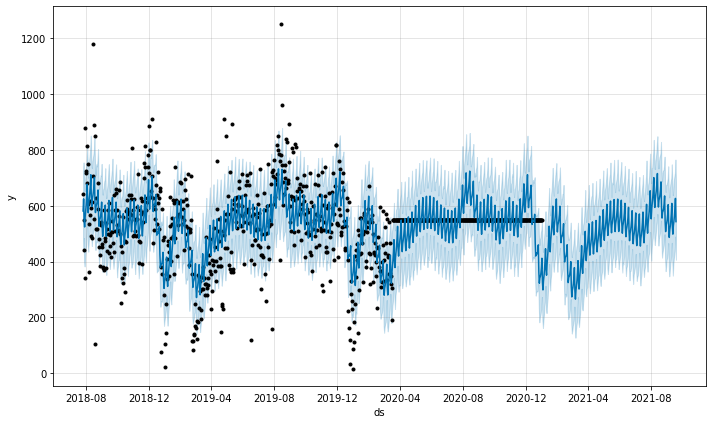

In [38]:
# Output a plot for the forecast
fig = model.plot(forecast)

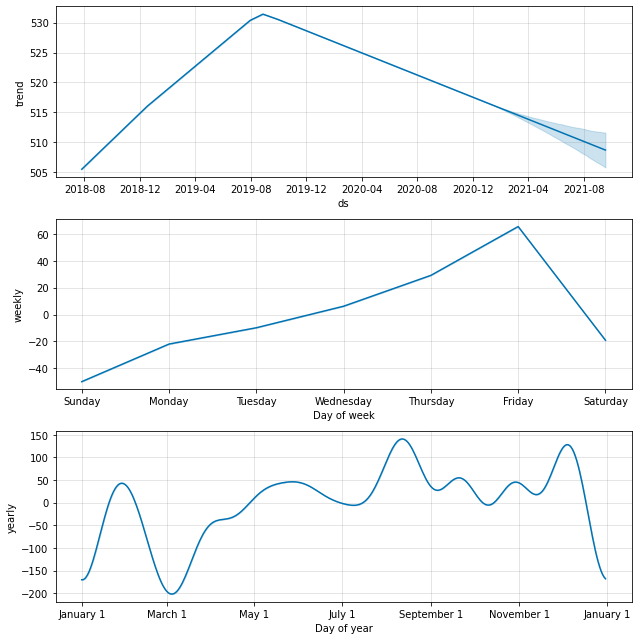

In [39]:
# Output plotted components – trend line, weekly, yearly
fig2 = model.plot_components(forecast)

In [40]:
# Interactive forecast
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

In [41]:
# Interactive component forecasts
plot_components_plotly(model, forecast)

In [42]:
# Doing cross validation (parameters outlined below)
# Creates dataframe "df_cv" with diagnostic data (true Ys and out-of-sample forecast Yhats)

from prophet.diagnostics import cross_validation

# "Initial" specifies how many days up until the first cutoff (366 days so that we can get yearly seasonality)
    # In other words the size of the initial training period
# "Period" is spacing between cutoff dates
# "Horizon" is forecast horizon from cutoff
# @Cath maybe easier to visualize all this – link here: https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation
# Rebe and I decided on these numbers in a meeting but ofc as above if the data fits something else better, feel free to change

df_cv = cross_validation(model, initial= '366 days', period = '30 days', horizon = '30 days')

INFO:prophet:Making 17 forecasts with cutoffs between 2019-08-10 00:00:00 and 2020-12-02 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

Initial log joint probability = -11.2954
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.439   2.74716e-06       102.132      0.4239      0.4239      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       700.456   8.39526e-05       101.063   8.339e-07       0.001      172  LS failed, Hessian reset 
     158       700.476   7.14675e-09       100.606      0.3297      0.3297      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.48287
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       771.689   2.34424e-05       93.6242      0.5016      0.5016      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       771.694   6.25991e-07       89.3661   5.951e-09       0.00

In [43]:
# Pull error metrics (per modeling guidelines, focus on MAE and RSME)
# Creates dataframe "df_em" and displays the first few
from prophet.diagnostics import performance_metrics
df_em = performance_metrics(df_cv)
df_em.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,18497.982136,136.007287,102.152725,0.187210,0.155056,0.188415,0.784314
1,4 days,17417.615515,131.975814,92.971981,0.189417,0.125716,0.179035,0.764706
2,5 days,12976.605745,113.914906,73.912114,0.148488,0.087298,0.141814,0.862745
3,6 days,8049.652554,89.719856,67.961947,0.145509,0.092525,0.138880,0.823529
4,7 days,6973.970418,83.510301,68.647245,0.128777,0.121200,0.130206,0.901961


In [44]:
# To see the error metrics at the end of the horizon
df_em.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,37900.849511,194.681405,151.580345,0.702627,0.213638,0.378961,0.588235
24,27 days,30788.479370,175.466462,132.473582,0.307551,0.172499,0.311407,0.647059
25,28 days,28194.434210,167.911984,124.225260,0.244100,0.171655,0.278771,0.666667
26,29 days,25242.332628,158.878358,119.318560,0.221879,0.171655,0.260082,0.666667
27,30 days,26504.776427,162.802876,129.008304,0.247237,0.201127,0.283728,0.607843


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



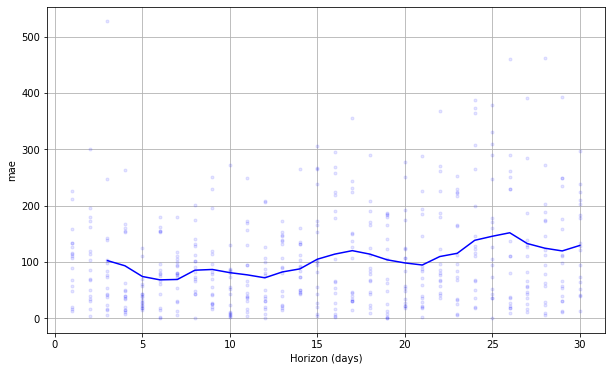

In [45]:
# Visualize MAE
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mae')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



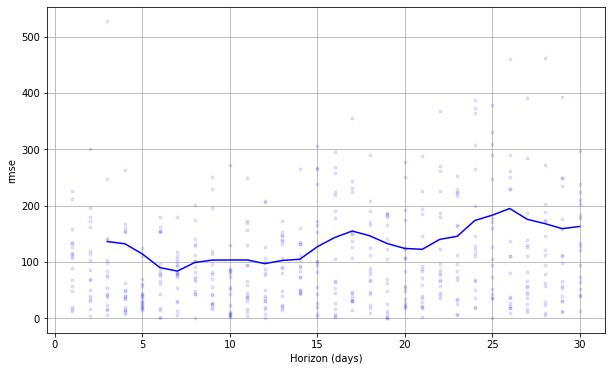

In [46]:
# Visualize RMSE
from prophet.plot import plot_cross_validation_metric
fig4 = plot_cross_validation_metric(df_cv, metric='rmse')

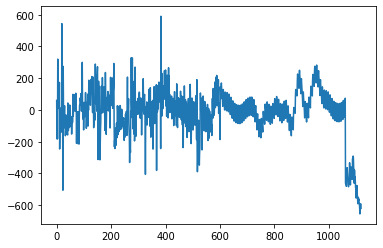

In [47]:
# Plotting residuals
from matplotlib import pyplot

y = df['y']
yhat = forecast['yhat']
residuals = y - yhat

residuals.plot()
pyplot.show()

In [48]:
# Information on the residuals
print(residuals.describe())

count    1119.000000
mean      -12.676382
std       150.694119
min      -655.288735
25%       -64.441675
50%         7.395458
75%        64.710070
max       590.464816
dtype: float64


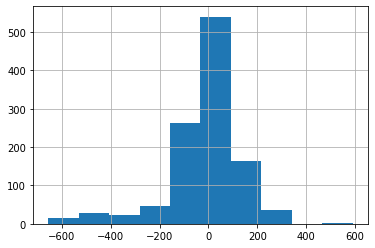

In [49]:
# Histogram of residuals
residuals.hist()
pyplot.show()

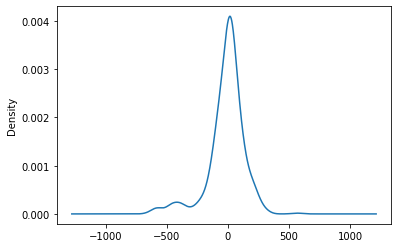

In [50]:
# Kernel density estimate visualization (estimates the PDF for the residuals)
residuals.plot(kind='kde')
pyplot.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



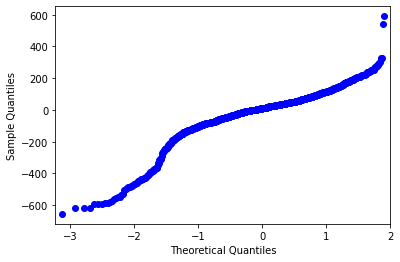

In [51]:
# Q-Q plot
import numpy
import statsmodels.api
from statsmodels.graphics.gofplots import qqplot

residuals1 = numpy.array(residuals)
qqplot(residuals1)
pyplot.show()